In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


## Rng strategies

In [3]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [3]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())

# set file name here
swarm_file = 'EP_BearishCollarBrokenWing_PointAndFigurePatterns_Short'

# Real swarm from .swm
df = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')
df = df.swarm

In [4]:
df = pd.DataFrame()

for file in glob.glob("./portfolios/*.csv"):
    
    portfolio_df = pd.read_csv(file, dayfirst=True, index_col=[0], parse_dates=[0], names=['date', file.split('\\')[1].split('.')[0]])
    portfolio_df = portfolio_df.groupby(portfolio_df.index).last().asfreq(BDay())
    
    #portfolio_df.columns[0] = file.split('\\')[1].split('.')[0]
    
    if len(df) == 0:
        df = portfolio_df
    else:
        df = pd.concat([df, portfolio_df],axis=1)
        
df = df.ffill().fillna(0.0)

In [84]:
all_equities_sum = df.sum(axis=1)

In [7]:
swarm = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')

FileNotFoundError: [Errno 2] No such file or directory: './temp_swarms/GCE_CallSpread_SwingPoint_Long_bearish_breakout_Aggresive_Long (Small SPL).swm'

## Systems overall performance estimation

In [4]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)

In [5]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))

In [6]:
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-5721.0,24530.0,0.056313,1.330626,4.287712,23.764535,"(-1, 100, 2, 0.05, 1, 0, 15)",0
1,-6170.0,23578.5,0.051168,1.267076,3.821475,26.962209,"(-1, 100, 2, 0.05, 1, 0, 25)",0
2,-6615.0,21137.5,0.041254,1.194583,3.195389,29.651163,"(-1, 100, 2, 0.05, 1, 0, 35)",0
3,-5719.0,38570.0,0.066598,1.301422,6.744186,35.392442,"(-1, 100, 2, 0.05, 1, 0, 45)",0
4,-5511.5,13602.0,0.036578,1.324820,2.467931,11.773256,"(-1, 100, 2, 0.05, 1, 0, 5)",0
5,-5889.5,30626.5,0.052026,1.221909,5.200187,36.191860,"(-1, 100, 2, 0.05, 1, 0, 55)",0
6,-9308.0,16131.5,0.034996,1.189842,1.733079,24.200581,"(-1, 100, 2, 0.05, 1, 1, 15)",0
7,-8443.5,15529.0,0.031219,1.162215,1.839166,25.145349,"(-1, 100, 2, 0.05, 1, 1, 25)",0
8,-15391.0,1265.5,0.002527,1.012668,0.082223,22.601744,"(-1, 100, 2, 0.05, 1, 1, 35)",0
9,-10098.0,13317.5,0.024281,1.110686,1.318826,30.305233,"(-1, 100, 2, 0.05, 1, 1, 45)",0


## Strategies overall performance ranking

In [7]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [8]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
1782,-2529.5,23107.5,0.083376,1.812714,9.135205,11.264535,"(-1, 600, 5, 0.05, 1, 0, 15)",50
1786,-2159.5,19092.5,0.075284,2.032864,8.841167,6.976744,"(-1, 600, 5, 0.05, 1, 0, 5)",50
1272,-886.5,11932.0,0.087678,3.330241,13.459673,4.360465,"(-1, 400, 5, 0.05, 1, 5, 15)",49
1783,-4031.5,26665.0,0.079926,1.595134,6.614163,15.552326,"(-1, 600, 5, 0.05, 1, 0, 25)",48
2185,-2501.5,14648.5,0.068891,1.855187,5.855886,6.686047,"(-1, 800, 2, 0.05, 1, 4, 25)",48
1545,-2795.0,15210.5,0.063624,1.643981,5.442039,10.101744,"(-1, 500, 5, 0.05, 1, 5, 45)",48
2197,-2501.5,14648.5,0.068891,1.855187,5.855886,6.686047,"(-1, 800, 2, 0.05, 1, 6, 25)",48
354,-1606.5,9559.5,0.067440,1.839068,5.950514,6.686047,"(-1, 1000, 3, 0.05, 1, 5, 15)",48
901,-1171.5,8015.5,0.070203,2.105662,6.842083,4.869186,"(-1, 300, 3, 0.05, 1, 6, 25)",48
1273,-1695.0,14159.5,0.085901,2.361098,8.353687,5.959302,"(-1, 400, 5, 0.05, 1, 5, 25)",48


## Drop all strategies which have rank score less than n quantile value 

In [9]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.5)].strategy]

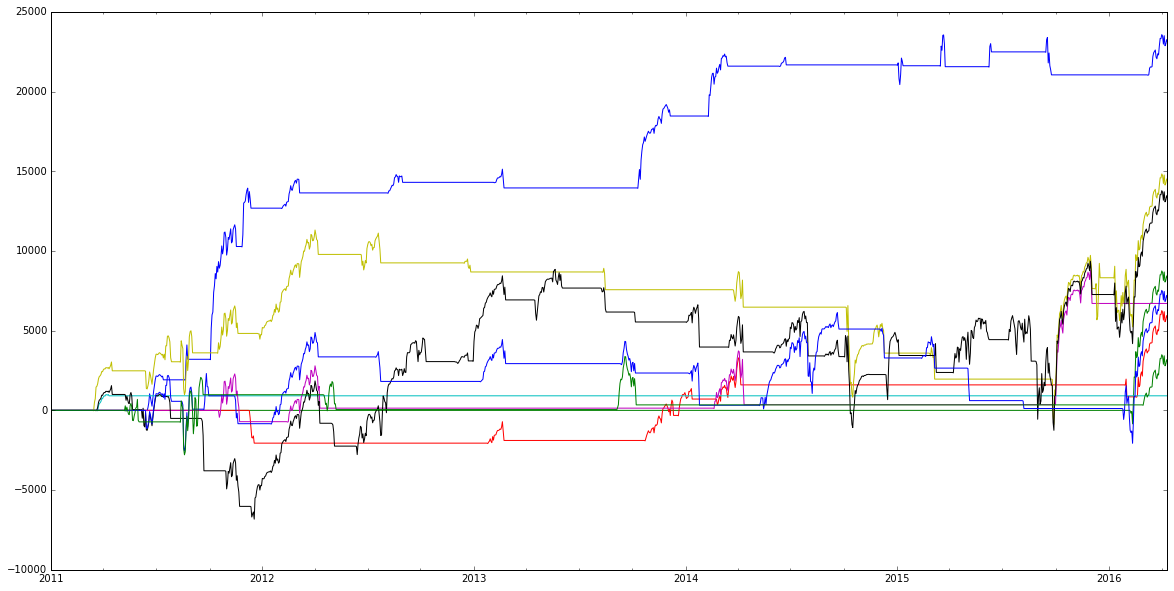

In [32]:
df.dropna().plot(legend=False)

## Filter those strategies by correlation

In [10]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).strategy, axis=1).dropna(axis=1).asfreq(BDay())

In [41]:
df.corr()

strategy,"(-1, 600, 5, 0.05, 1, 0, 15)","(-1, 600, 5, 0.05, 1, 0, 5)","(-1, 400, 5, 0.05, 1, 5, 15)","(-1, 600, 5, 0.05, 1, 0, 25)","(-1, 800, 2, 0.05, 1, 4, 25)","(-1, 500, 5, 0.05, 1, 5, 45)","(-1, 800, 2, 0.05, 1, 6, 25)","(-1, 1000, 3, 0.05, 1, 5, 15)","(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 400, 5, 0.05, 1, 5, 25)",...,"(-1, 300, 3, 0.05, 1, 2, 25)","(-1, 400, 2, 0.05, 1, 3, 5)","(-1, 300, 5, 0.05, 1, 1, 5)","(-1, 400, 2, 0.05, 1, 6, 35)","(-1, 400, 2, 0.05, 1, 4, 35)","(-1, 400, 2, 0.05, 1, 2, 55)","(-1, 400, 5, 0.05, 1, 2, 35)","(-1, 400, 4, 0.05, 1, 2, 35)","(-1, 200, 6, 0.05, 1, 1, 5)","(-1, 400, 2, 0.05, 1, 5, 15)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 600, 5, 0.05, 1, 0, 15)",1.000000,0.995276,0.933231,0.997216,0.926885,0.945796,0.926885,0.862191,0.859517,0.935895,...,0.724106,0.721327,0.533941,0.020289,0.020289,0.293969,0.659152,0.687618,0.811395,0.763668
"(-1, 600, 5, 0.05, 1, 0, 5)",0.995276,1.000000,0.908655,0.993978,0.936357,0.934459,0.936357,0.842101,0.829093,0.913024,...,0.671882,0.699436,0.490254,0.030404,0.030404,0.311579,0.644399,0.660092,0.785237,0.761772
"(-1, 400, 5, 0.05, 1, 5, 15)",0.933231,0.908655,1.000000,0.934227,0.860696,0.963918,0.860696,0.907994,0.854782,0.998188,...,0.862908,0.711718,0.678793,0.012089,0.012089,0.185075,0.661646,0.706941,0.813480,0.783057
"(-1, 600, 5, 0.05, 1, 0, 25)",0.997216,0.993978,0.934227,1.000000,0.939784,0.949708,0.939784,0.867052,0.854600,0.939675,...,0.719020,0.721911,0.535155,0.032352,0.032352,0.282997,0.660533,0.682050,0.800903,0.777140
"(-1, 800, 2, 0.05, 1, 4, 25)",0.926885,0.936357,0.860696,0.939784,1.000000,0.882960,1.000000,0.857792,0.779089,0.870628,...,0.611415,0.624879,0.583896,0.076536,0.076536,0.251971,0.682188,0.666415,0.742005,0.861584
"(-1, 500, 5, 0.05, 1, 5, 45)",0.945796,0.934459,0.963918,0.949708,0.882960,1.000000,0.882960,0.887448,0.804080,0.969538,...,0.769831,0.698813,0.574700,-0.011595,-0.011595,0.215410,0.596714,0.627713,0.764346,0.769227
"(-1, 800, 2, 0.05, 1, 6, 25)",0.926885,0.936357,0.860696,0.939784,1.000000,0.882960,1.000000,0.857792,0.779089,0.870628,...,0.611415,0.624879,0.583896,0.076536,0.076536,0.251971,0.682188,0.666415,0.742005,0.861584
"(-1, 1000, 3, 0.05, 1, 5, 15)",0.862191,0.842101,0.907994,0.867052,0.857792,0.887448,0.857792,1.000000,0.855460,0.909310,...,0.777135,0.604834,0.746548,0.192415,0.192415,0.268498,0.718917,0.783529,0.767609,0.753090
"(-1, 300, 3, 0.05, 1, 6, 25)",0.859517,0.829093,0.854782,0.854600,0.779089,0.804080,0.779089,0.855460,1.000000,0.849209,...,0.794406,0.818873,0.711267,0.197878,0.197878,0.194577,0.727870,0.794893,0.821739,0.673215


In [11]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.8)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [43]:
df.corr()

strategy,"(-1, 600, 5, 0.05, 1, 0, 15)","(-1, 1000, 3, 0.05, 1, 5, 15)","(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 400, 3, 0.05, 1, 2, 15)","(-1, 1000, 2, 0.05, 1, 2, 15)","(-1, 700, 3, 0.05, 1, 1, 15)","(-1, 600, 5, 0.05, 1, 5, 15)","(-1, 700, 3, 0.05, 1, 5, 45)","(-1, 600, 3, 0.05, 1, 1, 55)","(-1, 700, 6, 0.05, 1, 5, 15)",...,"(-1, 100, 4, 0.05, 1, 1, 45)","(-1, 1000, 3, 0.05, 1, 0, 55)","(-1, 700, 3, 0.05, 1, 4, 25)","(-1, 100, 6, 0.05, 1, 0, 35)","(-1, 800, 3, 0.05, 1, 1, 45)","(-1, 800, 3, 0.05, 1, 2, 55)","(-1, 700, 4, 0.05, 1, 0, 45)","(-1, 400, 2, 0.05, 1, 3, 5)","(-1, 400, 2, 0.05, 1, 2, 55)","(-1, 400, 4, 0.05, 1, 2, 35)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 600, 5, 0.05, 1, 0, 15)",1.000000,0.862191,0.859517,0.768672,0.779192,0.834679,0.581142,0.541130,0.889431,0.164294,...,0.170437,-0.135435,0.613624,0.788834,0.524299,0.613983,0.440638,0.721327,0.293969,0.687618
"(-1, 1000, 3, 0.05, 1, 5, 15)",0.862191,1.000000,0.855460,0.857957,0.795287,0.884015,0.816884,0.773543,0.864436,0.303608,...,0.202590,-0.275637,0.712351,0.604753,0.665807,0.662285,0.412232,0.604834,0.268498,0.783529
"(-1, 300, 3, 0.05, 1, 6, 25)",0.859517,0.855460,1.000000,0.840191,0.736731,0.711477,0.628505,0.582481,0.733695,0.201557,...,0.060739,-0.314025,0.636587,0.524256,0.551456,0.650583,0.359225,0.818873,0.194577,0.794893
"(-1, 400, 3, 0.05, 1, 2, 15)",0.768672,0.857957,0.840191,1.000000,0.825229,0.735769,0.598245,0.641810,0.709710,0.344753,...,0.184961,-0.407232,0.748513,0.471309,0.703024,0.747259,0.482748,0.576541,0.318080,0.895589
"(-1, 1000, 2, 0.05, 1, 2, 15)",0.779192,0.795287,0.736731,0.825229,1.000000,0.787900,0.511806,0.633559,0.805344,0.201481,...,0.473104,-0.242117,0.826228,0.664416,0.756147,0.803382,0.659414,0.546106,0.156646,0.669314
"(-1, 700, 3, 0.05, 1, 1, 15)",0.834679,0.884015,0.711477,0.735769,0.787900,1.000000,0.727761,0.768379,0.878037,0.445117,...,0.348613,-0.128160,0.733667,0.706451,0.677147,0.592173,0.594189,0.566661,0.298486,0.547136
"(-1, 600, 5, 0.05, 1, 5, 15)",0.581142,0.816884,0.628505,0.598245,0.511806,0.727761,1.000000,0.897793,0.722919,0.490513,...,0.155155,-0.080565,0.599179,0.305469,0.425483,0.419751,0.139879,0.445976,0.288312,0.462825
"(-1, 700, 3, 0.05, 1, 5, 45)",0.541130,0.773543,0.582481,0.641810,0.633559,0.768379,0.897793,1.000000,0.768980,0.656401,...,0.431438,-0.018384,0.688141,0.321325,0.625455,0.448748,0.397445,0.380131,0.285863,0.458371
"(-1, 600, 3, 0.05, 1, 1, 55)",0.889431,0.864436,0.733695,0.709710,0.805344,0.878037,0.722919,0.768980,1.000000,0.362685,...,0.465958,0.111936,0.692290,0.772395,0.587668,0.617952,0.494241,0.587771,0.335685,0.561084


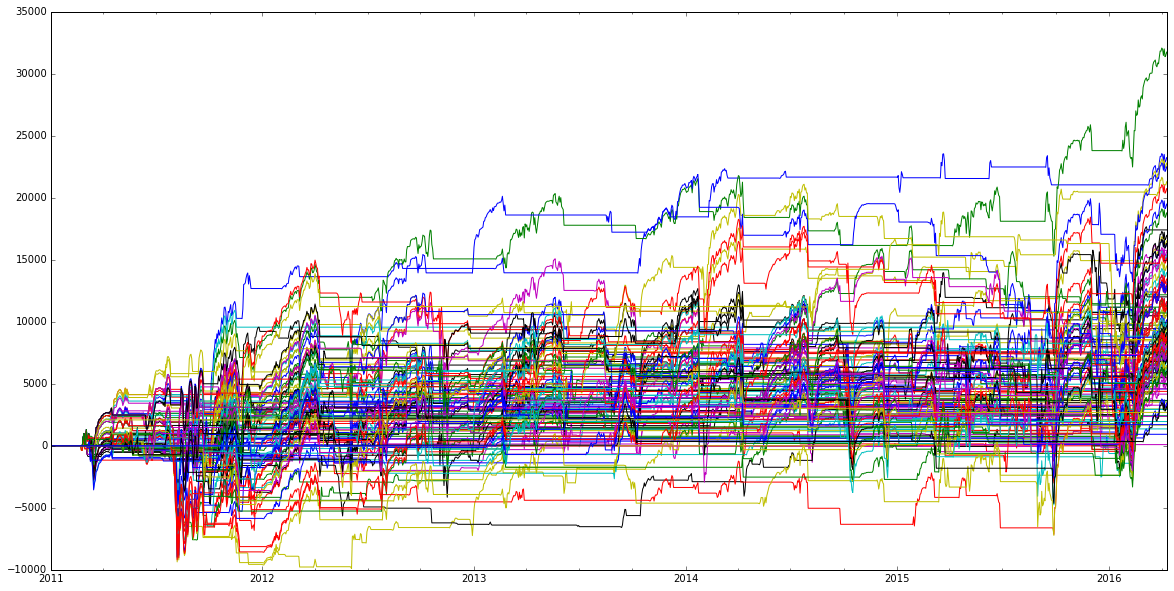

In [44]:
df.dropna().plot(legend=False)

# Metrics calculation

In [12]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate }
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [13]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [14]:
stats_df

,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
1029,2011-02-28,2011-02-21,9,-24.0,996.0,0.752411,42.500000,41.500000,60.000000,"(-1, 200, 5, 0.05, 1, 0, 5)"
1030,2011-02-28,2011-02-21,9,-24.0,993.5,0.749466,42.395833,41.395833,40.000000,"(-1, 200, 6, 0.05, 1, 4, 35)"
1035,2011-02-28,2011-02-21,9,-369.0,651.0,0.381254,2.764228,1.764228,60.000000,"(-1, 300, 3, 0.05, 1, 0, 25)"
1038,2011-02-28,2011-02-21,9,-369.0,651.0,0.381254,2.764228,1.764228,60.000000,"(-1, 300, 3, 0.05, 1, 0, 5)"
1049,2011-02-28,2011-02-21,9,-369.0,651.0,0.381254,2.764228,1.764228,60.000000,"(-1, 300, 2, 0.05, 1, 0, 5)"
1050,2011-02-28,2011-02-21,9,-24.0,996.0,0.752411,42.500000,41.500000,60.000000,"(-1, 500, 2, 0.05, 1, 0, 5)"
1052,2011-02-28,2011-02-21,9,-24.0,993.5,0.749466,42.395833,41.395833,40.000000,"(-1, 200, 6, 0.05, 1, 0, 35)"
1072,2011-02-28,2011-02-21,9,-24.0,996.0,0.752411,42.500000,41.500000,60.000000,"(-1, 200, 5, 0.05, 1, 0, 55)"
1076,2011-02-28,2011-02-21,9,-24.0,993.5,0.749466,42.395833,41.395833,40.000000,"(-1, 200, 6, 0.05, 1, 0, 55)"
1078,2011-02-28,2011-02-21,9,-24.0,996.0,0.752411,42.500000,41.500000,60.000000,"(-1, 200, 4, 0.05, 1, 0, 55)"


## Statistics rank calculation

In [15]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index --- 49
rebalance index --- 50
rebalance index --- 51
rebalance in

### Strategies picker

In [16]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Rebalance history


In [17]:
rebalance_history_df = pd.DataFrame(rebalance_history_l)
rebalance_history_df.index = rebalance_history_df.rebalance_index


same_strats_counter = 0
different_strats_counter = 0

same_strats_counter_l = []
different_strats_counter_l = []

for i in rebalance_history_df.index:
    
    if i > rebalance_history_df.index[0]+1:
        
        for c in rebalance_history_df.columns:
            
            if 'strategy' in c:
                
                if rebalance_history_df[c][i] in rebalance_history_df.best_strategies_list[i-1]:
                    same_strats_counter += 1
                
                if rebalance_history_df[c][i] not in rebalance_history_df.best_strategies_list[i-1]:
                    different_strats_counter += 1
    
    same_strats_counter_l.append(same_strats_counter)
    different_strats_counter_l.append(different_strats_counter)
    
    same_strats_counter = 0
    different_strats_counter = 0

rebalance_history_df['same_strategies'] = same_strats_counter_l
rebalance_history_df['different_strategies'] = different_strats_counter_l

In [18]:
rebalance_history_df

,best_strategies_list,rebalance_index,strategy_0,strategy_1,strategy_2,same_strategies,different_strategies
rebalance_index,,,,,,,
9,[],9,NaN,NaN,NaN,0,0
10,"[(-1, 200, 5, 0.05, 1, 0, 5), (-1, 500, 2, 0.0...",10,"(-1, 200, 5, 0.05, 1, 0, 5)","(-1, 500, 2, 0.05, 1, 0, 5)","(-1, 200, 5, 0.05, 1, 0, 55)",0,0
11,"[(-1, 100, 6, 0.05, 1, 0, 35), (-1, 100, 3, 0....",11,"(-1, 100, 6, 0.05, 1, 0, 35)","(-1, 100, 3, 0.05, 1, 0, 45)","(-1, 100, 4, 0.05, 1, 0, 45)",0,3
12,"[(-1, 100, 6, 0.05, 1, 0, 35), (-1, 100, 3, 0....",12,"(-1, 100, 6, 0.05, 1, 0, 35)","(-1, 100, 3, 0.05, 1, 0, 45)","(-1, 500, 2, 0.05, 1, 6, 45)",2,1
13,"[(-1, 300, 3, 0.05, 1, 6, 25), (-1, 400, 2, 0....",13,"(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 400, 2, 0.05, 1, 6, 25)","(-1, 300, 3, 0.05, 1, 0, 35)",0,3
14,"[(-1, 300, 3, 0.05, 1, 6, 25), (-1, 300, 2, 0....",14,"(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 300, 2, 0.05, 1, 3, 25)","(-1, 300, 2, 0.05, 1, 0, 5)",1,2
15,"[(-1, 300, 3, 0.05, 1, 6, 25), (-1, 300, 2, 0....",15,"(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 300, 2, 0.05, 1, 3, 25)","(-1, 200, 5, 0.05, 1, 0, 5)",2,1
16,"[(-1, 300, 3, 0.05, 1, 6, 25), (-1, 700, 3, 0....",16,"(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 700, 3, 0.05, 1, 1, 15)","(-1, 600, 3, 0.05, 1, 1, 55)",1,2
17,"[(-1, 300, 3, 0.05, 1, 6, 25), (-1, 200, 5, 0....",17,"(-1, 300, 3, 0.05, 1, 6, 25)","(-1, 200, 5, 0.05, 1, 0, 35)","(-1, 200, 6, 0.05, 1, 0, 55)",1,2


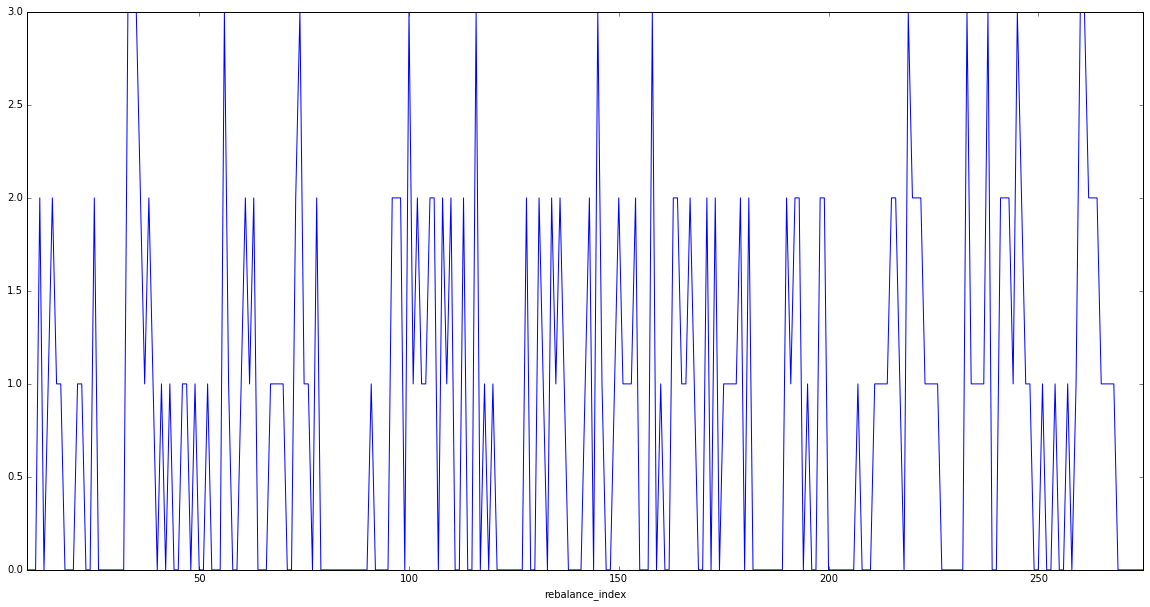

In [19]:
rebalance_history_df.same_strategies.plot()

In [20]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 0].count() / rebalance_history_df.same_strategies.count()

0.48689138576779029

In [21]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 1].count() / rebalance_history_df.same_strategies.count()

0.27340823970037453

In [22]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 2].count() / rebalance_history_df.same_strategies.count()

0.18352059925093633

In [23]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 3].count() / rebalance_history_df.same_strategies.count()

0.056179775280898875

## Comparing portfolios stats with benchmark(all strategies equity)

In [24]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.0994651719790455
Netprofit 147207.0
Max DD -13492.5
Recovery Factor 10.9102834908
Profit factor 1.41852630023
Winrate 45.2217364147


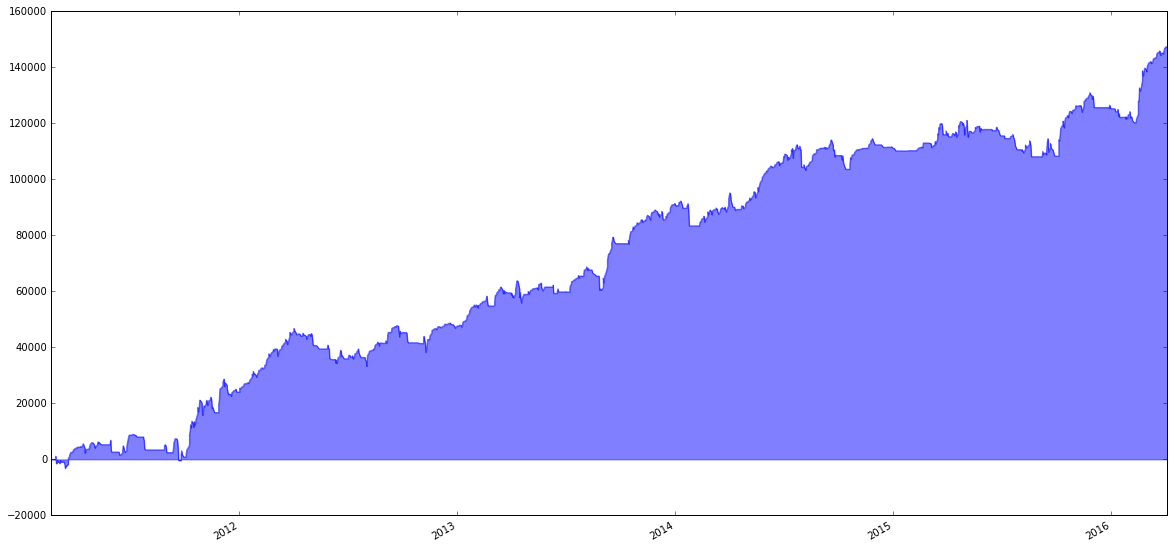

In [25]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.0008754436342340799
Netprofit 797.0
Max DD -16994.0
Recovery Factor 0.0468989054961
Profit factor 1.00904104772
Winrate 9.43160524672


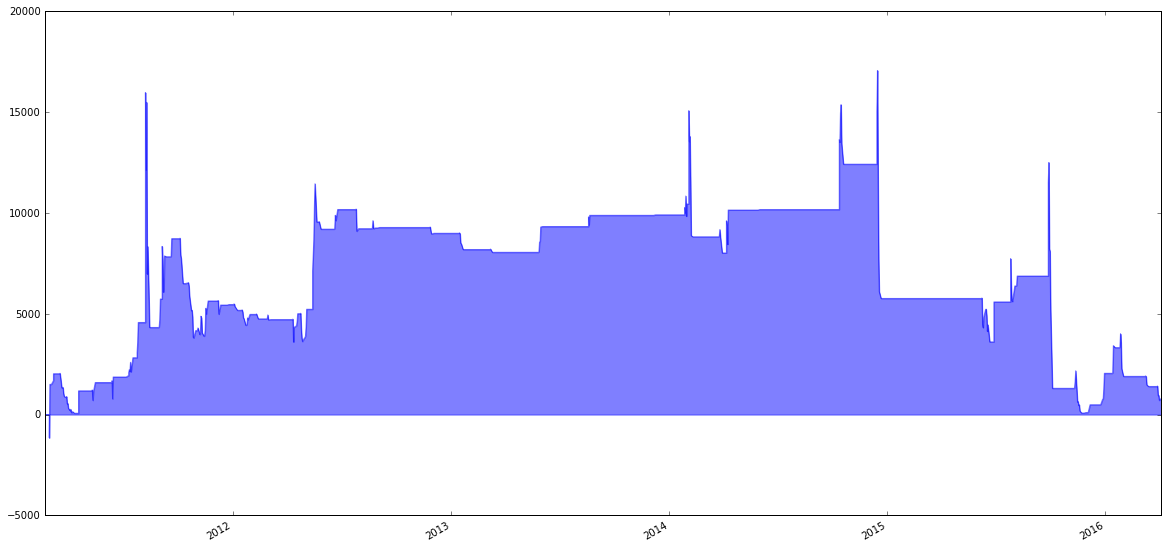

In [26]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.08820506737453619
Netprofit 148004.0
Max DD -18907.5
Recovery Factor 7.82779320376
Profit factor 1.37870894445
Winrate 47.532792005


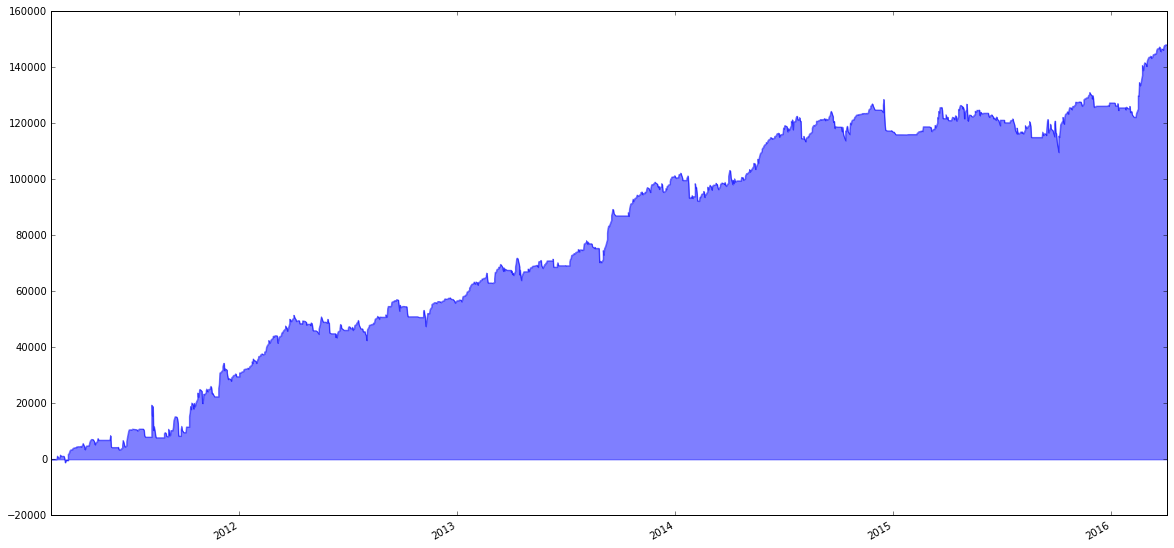

In [27]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe 0.0723638328720445
Netprofit 1729960.5
Max DD -276805.0
Recovery Factor 6.24974440491
Profit factor 1.27109459921
Winrate 58.7757651468


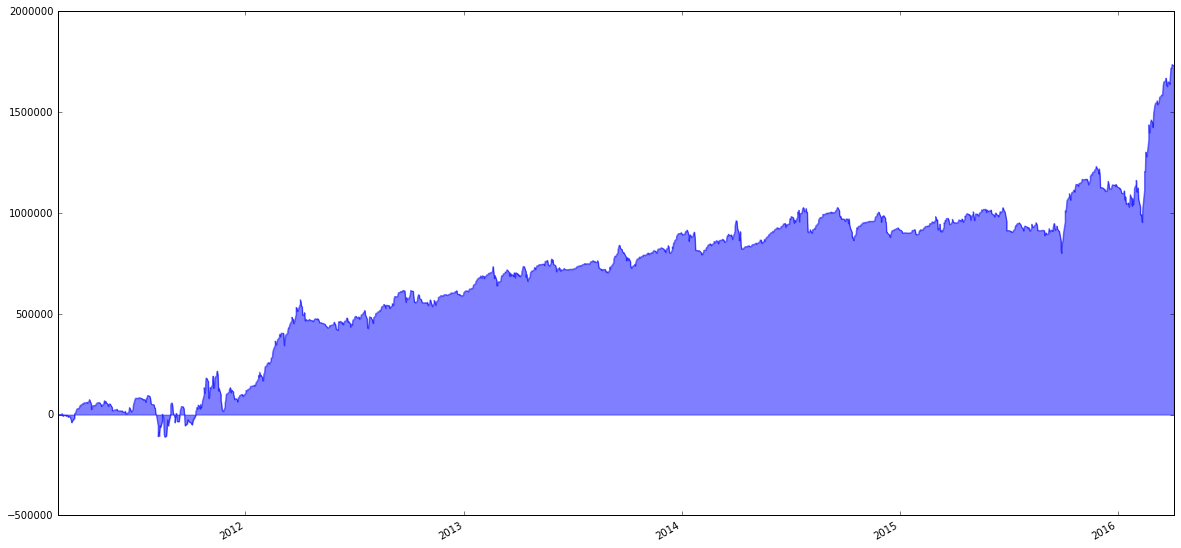

In [28]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [51]:
portfolio_stats(swarm.swarm_picked.sum(axis=1), 'Picked swarm with current approach')

NameError: name 'swarm' is not defined

Portfolio name --- All equities


PriceChange Mod. Sharpe 0.12604714366915892
Netprofit 500128.0
Max DD -33566.0
Recovery Factor 14.8998391229
Profit factor 1.51607683862
Winrate 57.8472222222


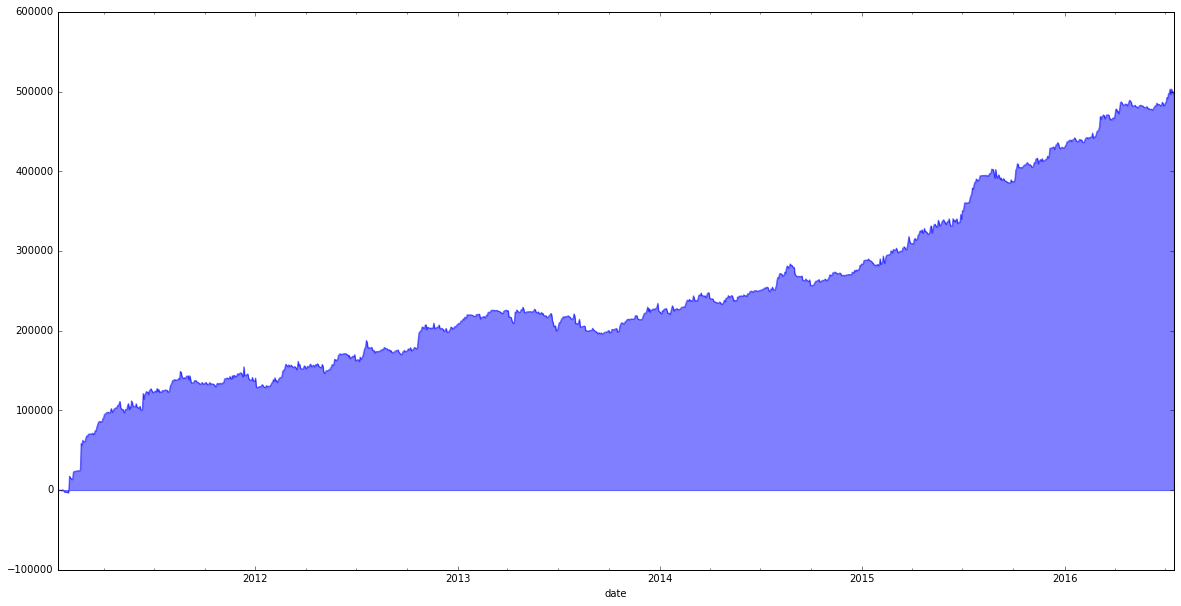

In [113]:
portfolio_stats(all_equities_sum, 'All equities')

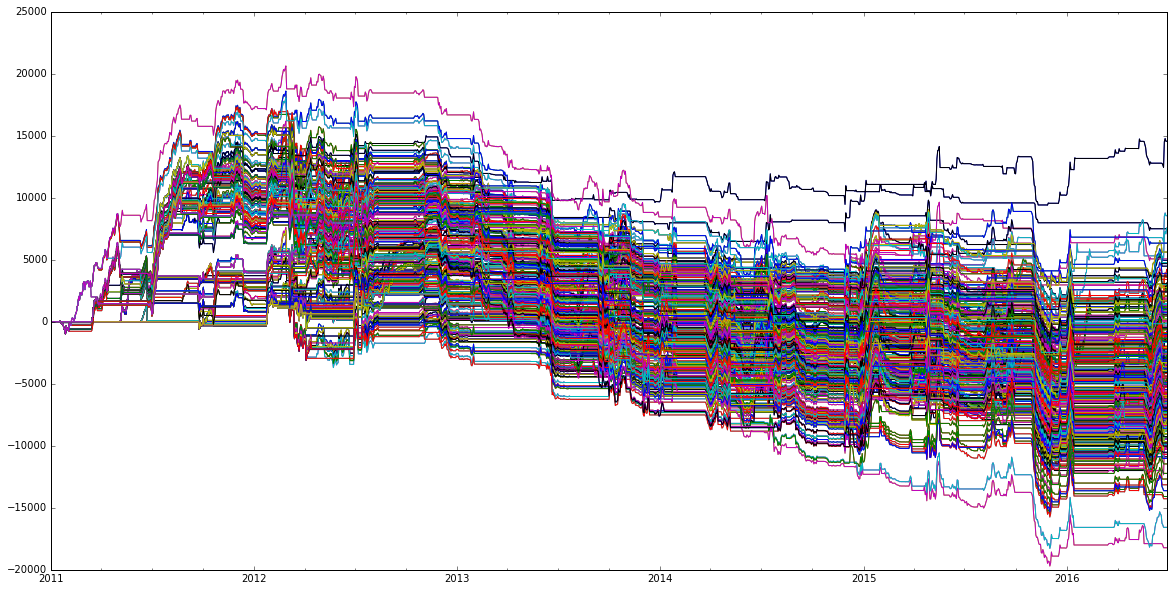

In [250]:
swarm.swarm.plot(legend=False)